# Image Inpainting and Image Coloring

In this project, I restore an old photograph of my parents and recolorize it. Later on, I will create a high resolution version of it.

### CheckPoint 1: Image Restoration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

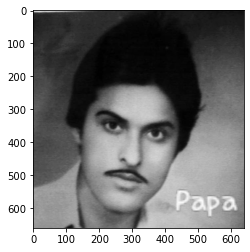

In [2]:
# Display the original Image
imageName = 'Papa.jpg'
image = cv2.imread(imageName, 0)
plt.imshow(image, cmap='gray')
plt.show()

#### Step 1: Create a custom Mask

I created the mask manually. Jupyter notebook was crashing again and again due to conflict with native python while opening an interactive window and hence, for sake of convenience I put that code in a .py file which you can find in this folder. The output of that file is a binary mask with white portions indicating the cracks.

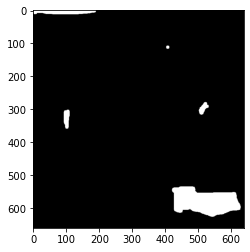

In [3]:
# display the mask
maskName = "mask" + imageName
maskImage = cv2.imread(maskName, 0)

plt.imshow(maskImage, cmap='gray')
plt.show()

#### Step 2: Restore the Image

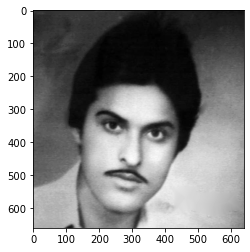

In [4]:
restoredImage = cv2.inpaint(image, maskImage,1000, cv2.INPAINT_TELEA)

plt.imshow(restoredImage, cmap='gray')
plt.show()

### Checkpoint 2: Colorizing the image

In [5]:
import time
from tkinter import filedialog
from tkinter import Tk
import sys
import os

#### Step 1: Load Colorization DNN model

In [6]:
architecture = '../models/colorization_deploy_v2.prototxt'
weights = '../models/colorization_release_v2.caffemodel'
net = cv2.dnn.readNetFromCaffe(architecture, weights)
points = np.load('../models/pts_in_hull.npy')
points = points.transpose()
points = points.reshape(2, 313, 1, 1)
pointsFloat32 = [points.astype("float32")]

In [7]:
cls_8 = net.getLayerId("class8_ab")
conv_8 = net.getLayerId("conv8_313_rh")

net.getLayer(cls_8).blobs = pointsFloat32
net.getLayer(conv_8).blobs = [np.full([1,313], 2.606, dtype="float32")]

#### Step 2: Pre-Process the image

In [8]:
# image = cv2.imread('Seattle.jpg')
# restoredImage = cv2.imread('Seattle.jpg',0)
scaledImage = restoredImage.astype("float32") / 255.0 # Normalize
colorImage = cv2.cvtColor(scaledImage, cv2.COLOR_GRAY2BGR)
labImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2LAB)
labImageResized = cv2.resize(labImage, (224,224))
channel_L = labImageResized[:,:,0] # L channel
channel_L -= 50

blob = cv2.dnn.blobFromImage(channel_L)
net.setInput(blob)

#### Step 3: Forward Pass

In [9]:
%%time
ab_channel = net.forward()

CPU times: user 1.03 s, sys: 32 ms, total: 1.06 s
Wall time: 297 ms


#### Step 4: Post-Processing

In [10]:
# print(ab_channel.shape)
ab_channel_resized = ab_channel[0, :, :, :].transpose((1,2,0))

# resize up
a_b = cv2.resize(ab_channel_resized, (restoredImage.shape[1], restoredImage.shape[0]))

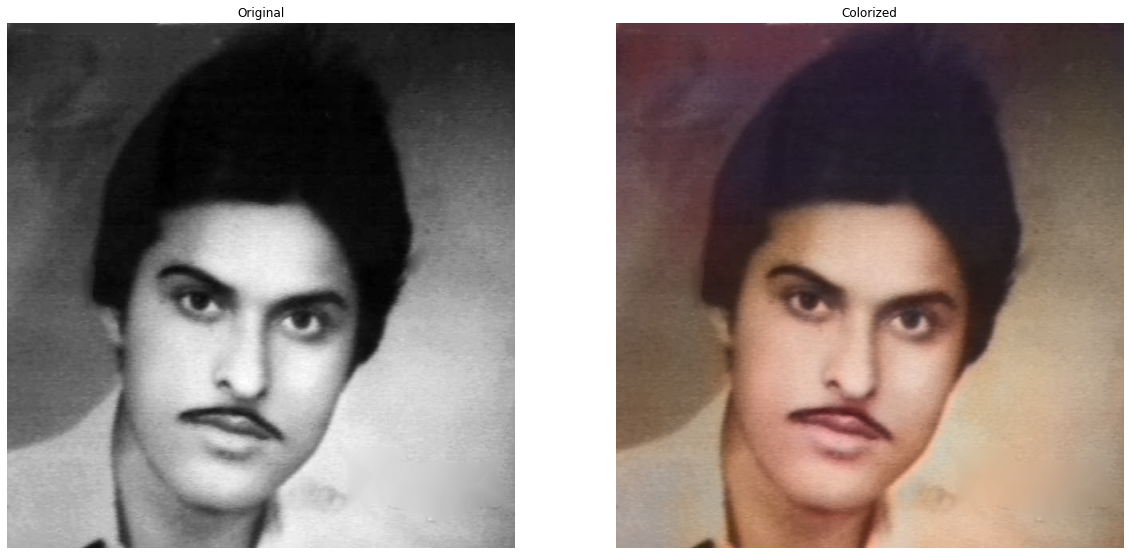

In [11]:
# Merging
channel_L = labImage[:,:,0]
colored = np.concatenate((channel_L[:,:,np.newaxis], a_b), axis=2)
# print(colored.shape)

# Change back to BGR
colored = cv2.cvtColor(colored, cv2.COLOR_LAB2BGR)
colored = np.clip(colored, 0, 1)
colored = (255*colored).astype("uint8")

plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(restoredImage, cmap='gray');plt.title("Original"); plt.axis("off");
plt.subplot(122); plt.imshow(colored[:,:,::-1]);plt.title("Colorized"); plt.axis("off");

In [12]:
# Save it
cv2.imwrite("RestoredImage.jpg", colored)

True